In [7]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [8]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
models_path = data_dir / "models"
train_images_crops = data_dir/"train_crops"
mask_dir_edt = data_dir /"mask_full_size_edt"
train_mask_crops = data_dir/"mask_crops_single_channel"
label_dir = data_dir/"train"/"labels"

In [9]:
data_dir = Path("/media/wwymak/Storage/xView2")
models_path = data_dir / "models"
classifcation_crop_dir = data_dir/"classification_crops_post"
classification_labels = pd.read_csv(data_dir/"train_pre_post.csv")
classification_labels["crop_filename"] = classification_labels.uuid.apply(lambda x: f"{x}.png")
damage_crops_test_folder = data_dir / "classification_crops_post"
classification_labels.head()

,uuid,img_id_pre,img_id_post,label,crop_filename
0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8.png
1,437988fc-fb7e-4b0e-8ccf-403015a737b3,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,437988fc-fb7e-4b0e-8ccf-403015a737b3.png
2,63d78637-7c40-40c7-a1b3-55152a64415a,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,63d78637-7c40-40c7-a1b3-55152a64415a.png
3,31ccdff0-b7f7-4884-8e55-d35e4d2c1770,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,31ccdff0-b7f7-4884-8e55-d35e4d2c1770.png
4,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b.png


In [10]:
classification_labels.label.value_counts()

0    121455
1     14987
2     14161
3     13238
Name: label, dtype: int64

In [11]:
def is_valid_func(fname, valid_ids):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]
    print(img_id)

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)
class CombinedLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha)
        
        total_loss = focal_loss(logit, target) #+ 0.2 * dice_loss(logit, y)
        return total_loss
    
def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#

In [12]:
unique_img_ids_undamaged= list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() if 'pre' in x.name ]))
unique_img_ids_damaged= list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() if 'post' in x.name ]))

print(len(unique_img_ids_damaged), len(unique_img_ids_undamaged))

np.random.seed(42)
np.random.shuffle(unique_img_ids_undamaged)
train_ids_undamaged = unique_img_ids_undamaged[:int(0.8 * len(unique_img_ids_undamaged))]
valid_ids_undamaged = unique_img_ids_undamaged[int(0.8 * len(unique_img_ids_undamaged)):]

train_ids_damaged = [x.replace('pre', 'post') for x in train_ids_undamaged]
valid_ids_damaged =[x.replace('pre', 'post') for x in valid_ids_undamaged]

print(len(train_ids_damaged), len(valid_ids_damaged))

2283 2283
1826 457


In [13]:
valid_ids_damaged[:5]

['hurricane-matthew_00000065_post_disaster',
 'hurricane-florence_00000300_post_disaster',
 'hurricane-michael_00000325_post_disaster',
 'palu-tsunami_00000056_post_disaster',
 'socal-fire_00000908_post_disaster']

In [14]:
classification_labels["is_valid"] = classification_labels.img_id_post.apply(lambda x: x.replace('.png', '') in valid_ids_damaged)

In [15]:
classification_labels["is_valid"].value_counts(normalize=True)

False    0.78398
True     0.21602
Name: is_valid, dtype: float64

In [16]:
datasets= []
classification_labels_0 = classification_labels[classification_labels.label==0].sample(frac=1.)
label_0_per_bag = 20000

for i in range(0, len(classification_labels_0) , label_0_per_bag):
    datasets.append(pd.concat([
        classification_labels[(classification_labels.label!= 0)],
        classification_labels[(classification_labels.label==0)][i: i+label_0_per_bag]
    ]).reset_index(drop=True))


In [17]:
for dataset in datasets:
    valset_len = dataset[dataset.is_valid==True].shape[0]
    dataset_len = len(dataset)
    print(f"dataset has {valset_len/dataset_len *100}% validation")

dataset has 19.19501170134325% validation
dataset has 22.246978488763506% validation
dataset has 20.474144840188504% validation
dataset has 18.46568140287885% validation
dataset has 18.165934664828647% validation
dataset has 21.269195011701346% validation
dataset has 18.608152186309617% validation


In [18]:
datasets[0].head()

,uuid,img_id_pre,img_id_post,label,crop_filename,is_valid
0,b7f18d58-1dc5-4c35-b77e-323d4eb08f8e,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,2,b7f18d58-1dc5-4c35-b77e-323d4eb08f8e.png,False
1,f9d70ffb-1cff-42ad-8ae4-5cd025c5f6df,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,2,f9d70ffb-1cff-42ad-8ae4-5cd025c5f6df.png,False
2,c47fdb93-fd1d-4104-b919-b64890c445d3,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,1,c47fdb93-fd1d-4104-b919-b64890c445d3.png,False
3,4ed00b10-e3f3-4175-b3e2-f65b5ed3eada,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,1,4ed00b10-e3f3-4175-b3e2-f65b5ed3eada.png,False
4,b9be07ec-fec9-409b-9990-921151be00f7,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,1,b9be07ec-fec9-409b-9990-921151be00f7.png,False


In [45]:
class CombinedCrossEntropyMSELoss(nn.Module):

    def __init__(self, frac_mse=0.5, frac_ce=0.5):
        super(CombinedCrossEntropyMSELoss, self).__init__()
        self.frac_mse = frac_mse
        self.frac_ce = frac_ce

    def forward(self, inputs, targets, **kwargs):
        predicted = torch.argmax(inputs, dim=1)
        #torch.Size([8, 9, 256, 256]) torch.Size([8, 1, 256, 256])
        ce_loss = CrossEntropyFlat()(inputs, targets)
        mse_loss = torch.nn.MSELoss()(predicted.float(), targets.float())
        
        total_loss = self.frac_mse * mse_loss + \
                self. frac_ce * ce_loss
        return total_loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


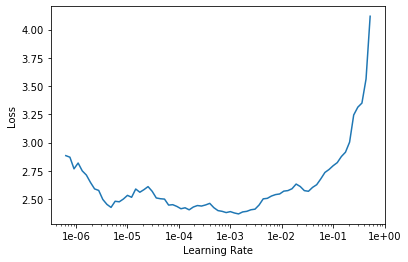

In [46]:
del learn
gc.collect()

# import geffnet
# mixnet = geffnet.mixnet_l(pretrained=True, drop_rate=0.25, drop_connect_rate=0.2, as_sequential=True)

size=128
bs=8
src = (ImageList
       .from_df(datasets[0], path=classifcation_crop_dir, cols=['crop_filename'])
       .split_from_df(col="is_valid")
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedCrossEntropyMSELoss();
learn.to_fp16();

learn.lr_find()
learn.recorder.plot();


In [47]:
learn.fit_one_cycle(5, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.190166,0.895295,0.637077,0.580790,03:45
1,1.026873,0.774133,0.686180,0.650745,03:44
2,0.962477,0.655145,0.742714,0.728505,03:48
3,0.897665,0.652966,0.739541,0.675434,03:51
4,0.920029,0.630765,0.752067,0.698407,03:47


In [49]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
        
    def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return self.lin_comb(loss/c, nll, self.ε)
    
def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)
class FocalCustomLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(FocalCustomLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha)
#         bce_dice = BCEDiceLoss()
#         lovaz_loss = LovaszLossBinary()
#         dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = focal_loss(logit, target) #+ 0.2 * dice_loss(logit, y)
        return total_loss

In [52]:
class CombinedLoss(nn.Module):

    def __init__(self, frac_mse=0.5, frac_ce=0.5):
        super(CombinedLoss, self).__init__()
        self.frac_mse = frac_mse
        self.frac_ce = frac_ce

    def forward(self, inputs, targets, **kwargs):
        predicted = torch.argmax(inputs, dim=1)
        #torch.Size([8, 9, 256, 256]) torch.Size([8, 1, 256, 256])
        focal_loss = FocalCustomLoss(gamma=4., alpha=0.75)(inputs, targets)
        mse_loss = torch.nn.MSELoss()(predicted.float(), targets.float())
        
        total_loss = self.frac_mse * mse_loss + \
                self. frac_ce * focal_loss
        return total_loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


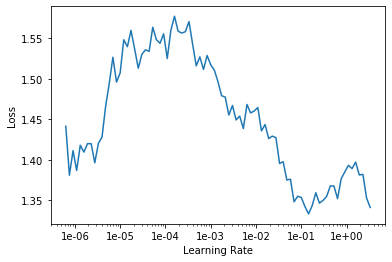

In [53]:
del learn
gc.collect()

# import geffnet
# mixnet = geffnet.mixnet_l(pretrained=True, drop_rate=0.25, drop_connect_rate=0.2, as_sequential=True)

size=128
bs=8
src = (ImageList
       .from_df(classification_labels, path=classifcation_crop_dir, cols=['crop_filename'])
       .split_from_df(col="is_valid")
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss();
learn.to_fp16();

learn.lr_find()
learn.recorder.plot();

In [54]:
callbacks=[
           ReduceLROnPlateauCallback(learn, patience=1, monitor='f1')
          ]
learn.fit_one_cycle(5, max_lr=1e-3, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.526534,0.309609,0.815020,0.762501,16:50
1,0.476863,0.276243,0.829430,0.822628,10:15
2,0.390994,0.275920,0.835702,0.836506,10:08
3,0.362164,0.249654,0.854180,0.852684,10:06
4,0.369393,0.238169,0.859916,0.857961,10:16


In [55]:
learn.save('29Dec-focal-mse-loss-damage-classification')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


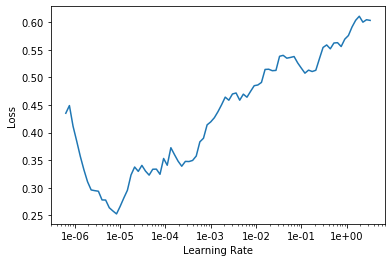

In [56]:
learn.load('29Dec-focal-mse-loss-damage-classification')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [57]:
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='29Dec-focal-mse-loss-damage-classification_unfrozen'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1, monitor='f1')
          ]

learn.fit_one_cycle(5, max_lr=slice(5e-6), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.344620,0.238636,0.859266,0.856077,13:48
1,0.374925,0.239201,0.859605,0.856973,13:54
2,0.373994,0.242846,0.857938,0.854629,14:08
3,0.366290,0.240995,0.859746,0.857192,14:07
4,0.374790,0.249790,0.853022,0.851213,14:25


Better model found at epoch 0 with f1 value: 0.8560771942138672.
Better model found at epoch 1 with f1 value: 0.8569734692573547.
Better model found at epoch 3 with f1 value: 0.8571917414665222.


In [58]:
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='29Dec-focal-mse-loss-damage-classification_unfrozen'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1, monitor='f1')
          ]

learn.fit_one_cycle(3, max_lr=slice(1e-6), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.357741,0.234547,0.861526,0.858671,14:12
1,0.286167,0.242295,0.859012,0.856736,14:02
2,0.315860,0.237100,0.861442,0.856725,14:07


Better model found at epoch 0 with f1 value: 0.8586714267730713.


In [59]:
learn.load('29Dec-focal-mse-loss-damage-classification');

In [61]:
data.test_dl.items[:4]

array([PosixPath('/media/wwymak/Storage/xView2/classification_crops_test/5a29c7c0-57ca-414e-84f5-c7c08dfddcbb.png'),
       PosixPath('/media/wwymak/Storage/xView2/classification_crops_test/eb8b588f-fedb-4848-9b3f-4b4ebb61d7c9.png'),
       PosixPath('/media/wwymak/Storage/xView2/classification_crops_test/285b8f4b-d2b8-4418-9be9-0042bd5c105d.png'),
       PosixPath('/media/wwymak/Storage/xView2/classification_crops_test/ad9ff17a-6f85-4280-801c-289be61e18db.png')],
      dtype=object)

In [62]:
learn.pred_batch(batch=next(iter(data.test_dl)))

tensor([[ 4.5068e-01, -6.7329e-04,  6.8311e-01, -2.5059e+00],
        [ 1.7891e+00, -7.6318e-01, -3.0840e+00, -5.1523e+00],
        [ 7.9932e-01,  6.0449e-01, -1.7275e+00, -1.3047e+00],
        [-8.1934e-01, -3.7988e+00,  5.3906e+00, -8.8750e+00],
        [ 4.6445e+00, -6.1953e+00, -8.3750e+00, -1.3516e+01],
        [ 3.3862e-01, -9.9316e-01,  1.6465e+00, -4.1562e+00],
        [ 2.2793e+00, -3.4453e+00, -4.0938e+00, -5.4375e+00],
        [ 1.1090e-01, -4.4946e-01,  2.0977e+00, -3.7793e+00]])

In [63]:
torch.max(learn.pred_batch(batch=next(iter(data.test_dl))), dim=1).indices.numpy()

array([2, 0, 0, 2, 0, 2, 0, 2])

In [67]:
test_damage_filenames =  data.test_dl.items
test_iterator = iter(data.test_dl)
pred_results = {}
i = 0
print("starting")
for batch in test_iterator:
    print(f"start_img {i}")
    batch_preds = learn.pred_batch(batch=batch)
    classification_results = torch.max(batch_preds, dim=1).indices.numpy()
    polygon_ids = [x.name for x in test_damage_filenames[i: i+batch_preds.shape[0]]]
    
    classification_results_dict = {k: v for (k, v) in zip(polygon_ids, classification_results)}
    pred_results = {**pred_results, **classification_results_dict}
    
    i+=len(polygon_ids)
    
print(len(pred_results.keys()))

starting
start_img 0
start_img 8
start_img 16
start_img 24
start_img 32
start_img 40
start_img 48
start_img 56
start_img 64
start_img 72
start_img 80
start_img 88
start_img 96
start_img 104
start_img 112
start_img 120
start_img 128
start_img 136
start_img 144
start_img 152
start_img 160
start_img 168
start_img 176
start_img 184
start_img 192
start_img 200
start_img 208
start_img 216
start_img 224
start_img 232
start_img 240
start_img 248
start_img 256
start_img 264
start_img 272
start_img 280
start_img 288
start_img 296
start_img 304
start_img 312
start_img 320
start_img 328
start_img 336
start_img 344
start_img 352
start_img 360
start_img 368
start_img 376
start_img 384
start_img 392
start_img 400
start_img 408
start_img 416
start_img 424
start_img 432
start_img 440
start_img 448
start_img 456
start_img 464
start_img 472
start_img 480
start_img 488
start_img 496
start_img 504
start_img 512
start_img 520
start_img 528
start_img 536
start_img 544
start_img 552
start_img 560
start_img 56

start_img 4480
start_img 4488
start_img 4496
start_img 4504
start_img 4512
start_img 4520
start_img 4528
start_img 4536
start_img 4544
start_img 4552
start_img 4560
start_img 4568
start_img 4576
start_img 4584
start_img 4592
start_img 4600
start_img 4608
start_img 4616
start_img 4624
start_img 4632
start_img 4640
start_img 4648
start_img 4656
start_img 4664
start_img 4672
start_img 4680
start_img 4688
start_img 4696
start_img 4704
start_img 4712
start_img 4720
start_img 4728
start_img 4736
start_img 4744
start_img 4752
start_img 4760
start_img 4768
start_img 4776
start_img 4784
start_img 4792
start_img 4800
start_img 4808
start_img 4816
start_img 4824
start_img 4832
start_img 4840
start_img 4848
start_img 4856
start_img 4864
start_img 4872
start_img 4880
start_img 4888
start_img 4896
start_img 4904
start_img 4912
start_img 4920
start_img 4928
start_img 4936
start_img 4944
start_img 4952
start_img 4960
start_img 4968
start_img 4976
start_img 4984
start_img 4992
start_img 5000
start_img 

start_img 8944
start_img 8952
start_img 8960
start_img 8968
start_img 8976
start_img 8984
start_img 8992
start_img 9000
start_img 9008
start_img 9016
start_img 9024
start_img 9032
start_img 9040
start_img 9048
start_img 9056
start_img 9064
start_img 9072
start_img 9080
start_img 9088
start_img 9096
start_img 9104
start_img 9112
start_img 9120
start_img 9128
start_img 9136
start_img 9144
start_img 9152
start_img 9160
start_img 9168
start_img 9176
start_img 9184
start_img 9192
start_img 9200
start_img 9208
start_img 9216
start_img 9224
start_img 9232
start_img 9240
start_img 9248
start_img 9256
start_img 9264
start_img 9272
start_img 9280
start_img 9288
start_img 9296
start_img 9304
start_img 9312
start_img 9320
start_img 9328
start_img 9336
start_img 9344
start_img 9352
start_img 9360
start_img 9368
start_img 9376
start_img 9384
start_img 9392
start_img 9400
start_img 9408
start_img 9416
start_img 9424
start_img 9432
start_img 9440
start_img 9448
start_img 9456
start_img 9464
start_img 

start_img 13120
start_img 13128
start_img 13136
start_img 13144
start_img 13152
start_img 13160
start_img 13168
start_img 13176
start_img 13184
start_img 13192
start_img 13200
start_img 13208
start_img 13216
start_img 13224
start_img 13232
start_img 13240
start_img 13248
start_img 13256
start_img 13264
start_img 13272
start_img 13280
start_img 13288
start_img 13296
start_img 13304
start_img 13312
start_img 13320
start_img 13328
start_img 13336
start_img 13344
start_img 13352
start_img 13360
start_img 13368
start_img 13376
start_img 13384
start_img 13392
start_img 13400
start_img 13408
start_img 13416
start_img 13424
start_img 13432
start_img 13440
start_img 13448
start_img 13456
start_img 13464
start_img 13472
start_img 13480
start_img 13488
start_img 13496
start_img 13504
start_img 13512
start_img 13520
start_img 13528
start_img 13536
start_img 13544
start_img 13552
start_img 13560
start_img 13568
start_img 13576
start_img 13584
start_img 13592
start_img 13600
start_img 13608
start_im

start_img 17296
start_img 17304
start_img 17312
start_img 17320
start_img 17328
start_img 17336
start_img 17344
start_img 17352
start_img 17360
start_img 17368
start_img 17376
start_img 17384
start_img 17392
start_img 17400
start_img 17408
start_img 17416
start_img 17424
start_img 17432
start_img 17440
start_img 17448
start_img 17456
start_img 17464
start_img 17472
start_img 17480
start_img 17488
start_img 17496
start_img 17504
start_img 17512
start_img 17520
start_img 17528
start_img 17536
start_img 17544
start_img 17552
start_img 17560
start_img 17568
start_img 17576
start_img 17584
start_img 17592
start_img 17600
start_img 17608
start_img 17616
start_img 17624
start_img 17632
start_img 17640
start_img 17648
start_img 17656
start_img 17664
start_img 17672
start_img 17680
start_img 17688
start_img 17696
start_img 17704
start_img 17712
start_img 17720
start_img 17728
start_img 17736
start_img 17744
start_img 17752
start_img 17760
start_img 17768
start_img 17776
start_img 17784
start_im

start_img 21472
start_img 21480
start_img 21488
start_img 21496
start_img 21504
start_img 21512
start_img 21520
start_img 21528
start_img 21536
start_img 21544
start_img 21552
start_img 21560
start_img 21568
start_img 21576
start_img 21584
start_img 21592
start_img 21600
start_img 21608
start_img 21616
start_img 21624
start_img 21632
start_img 21640
start_img 21648
start_img 21656
start_img 21664
start_img 21672
start_img 21680
start_img 21688
start_img 21696
start_img 21704
start_img 21712
start_img 21720
start_img 21728
start_img 21736
start_img 21744
start_img 21752
start_img 21760
start_img 21768
start_img 21776
start_img 21784
start_img 21792
start_img 21800
start_img 21808
start_img 21816
start_img 21824
start_img 21832
start_img 21840
start_img 21848
start_img 21856
start_img 21864
start_img 21872
start_img 21880
start_img 21888
start_img 21896
start_img 21904
start_img 21912
start_img 21920
start_img 21928
start_img 21936
start_img 21944
start_img 21952
start_img 21960
start_im

start_img 25640
start_img 25648
start_img 25656
start_img 25664
start_img 25672
start_img 25680
start_img 25688
start_img 25696
start_img 25704
start_img 25712
start_img 25720
start_img 25728
start_img 25736
start_img 25744
start_img 25752
start_img 25760
start_img 25768
start_img 25776
start_img 25784
start_img 25792
start_img 25800
start_img 25808
start_img 25816
start_img 25824
start_img 25832
start_img 25840
start_img 25848
start_img 25856
start_img 25864
start_img 25872
start_img 25880
start_img 25888
start_img 25896
start_img 25904
start_img 25912
start_img 25920
start_img 25928
start_img 25936
start_img 25944
start_img 25952
start_img 25960
start_img 25968
start_img 25976
start_img 25984
start_img 25992
start_img 26000
start_img 26008
start_img 26016
start_img 26024
start_img 26032
start_img 26040
start_img 26048
start_img 26056
start_img 26064
start_img 26072
start_img 26080
start_img 26088
start_img 26096
start_img 26104
start_img 26112
start_img 26120
start_img 26128
start_im

start_img 29824
start_img 29832
start_img 29840
start_img 29848
start_img 29856
start_img 29864
start_img 29872
start_img 29880
start_img 29888
start_img 29896
start_img 29904
start_img 29912
start_img 29920
start_img 29928
start_img 29936
start_img 29944
start_img 29952
start_img 29960
start_img 29968
start_img 29976
start_img 29984
start_img 29992
start_img 30000
start_img 30008
start_img 30016
start_img 30024
start_img 30032
start_img 30040
start_img 30048
start_img 30056
start_img 30064
start_img 30072
start_img 30080
start_img 30088
start_img 30096
start_img 30104
start_img 30112
start_img 30120
start_img 30128
start_img 30136
start_img 30144
start_img 30152
start_img 30160
start_img 30168
start_img 30176
start_img 30184
start_img 30192
start_img 30200
start_img 30208
start_img 30216
start_img 30224
start_img 30232
start_img 30240
start_img 30248
start_img 30256
start_img 30264
start_img 30272
start_img 30280
start_img 30288
start_img 30296
start_img 30304
start_img 30312
start_im

In [64]:
# predictions, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
# y = torch.argmax(predictions, dim=1)

test_labels = pd.read_csv(data_dir/"test_polygons.csv")

test_labels["crop_filename"] = test_labels.polygon_id.apply(lambda x: f"{x}.png")

polygon_ids = [x.name.replace('.png', '') for x in data.test_dl.dataset.items]
# prediction_cls = [x+1 for x in y.numpy()]

test_results = pd.DataFrame(data={'polygon_id': polygon_ids, 'damage_cls': prediction_cls})
test_results = test_labels.merge(test_results, left_on='polygon_id', right_on='polygon_id')
test_results.geometry = test_results.geometry.apply(lambda x: wkt.loads(x).exterior)
test_results.img_id = test_results.img_id.str.replace('localization', 'damage')

test_results.head()

NameError: name 'polygon_ids' is not defined